In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

import json

import imp
import datasets

import numpy as np

imp.reload(datasets)

from datasets import Dataset

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [5]:
SEED = 10

# Анализ данных

## Lenta

In [6]:
rubrics = ['Мир', 'Россия', 'Политика', 'Экономика', 'Наука и техника', 'Украина',
               'Госэкономика', 'Спорт', 'Общество', 'Бывший СССР', 'Культура', 'Медиа',
               'Футбол', 'Музыка', 'Наука']
lenta = Dataset(use_title=False, rubrics=rubrics, random_state=SEED, subsample=0.1)

W0528 12:52:50.050708 140735881241472 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


Instructions for updating:
Colocations handled automatically by placer.


W0528 12:52:54.120783 140735881241472 deprecation.py:323] From /Users/mikhail/anaconda3/envs/text_classifiers/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0528 12:52:56.996166 140735881241472 saver.py:1483] Saver not created because there are no variables in the graph to restore
processing docs: 100%|██████████| 3865/3865 [01:35<00:00, 40.51it/s]


### Баланс классов

In [4]:
classes_balance = lenta.get_classes_balance().sort_values(ascending=False)

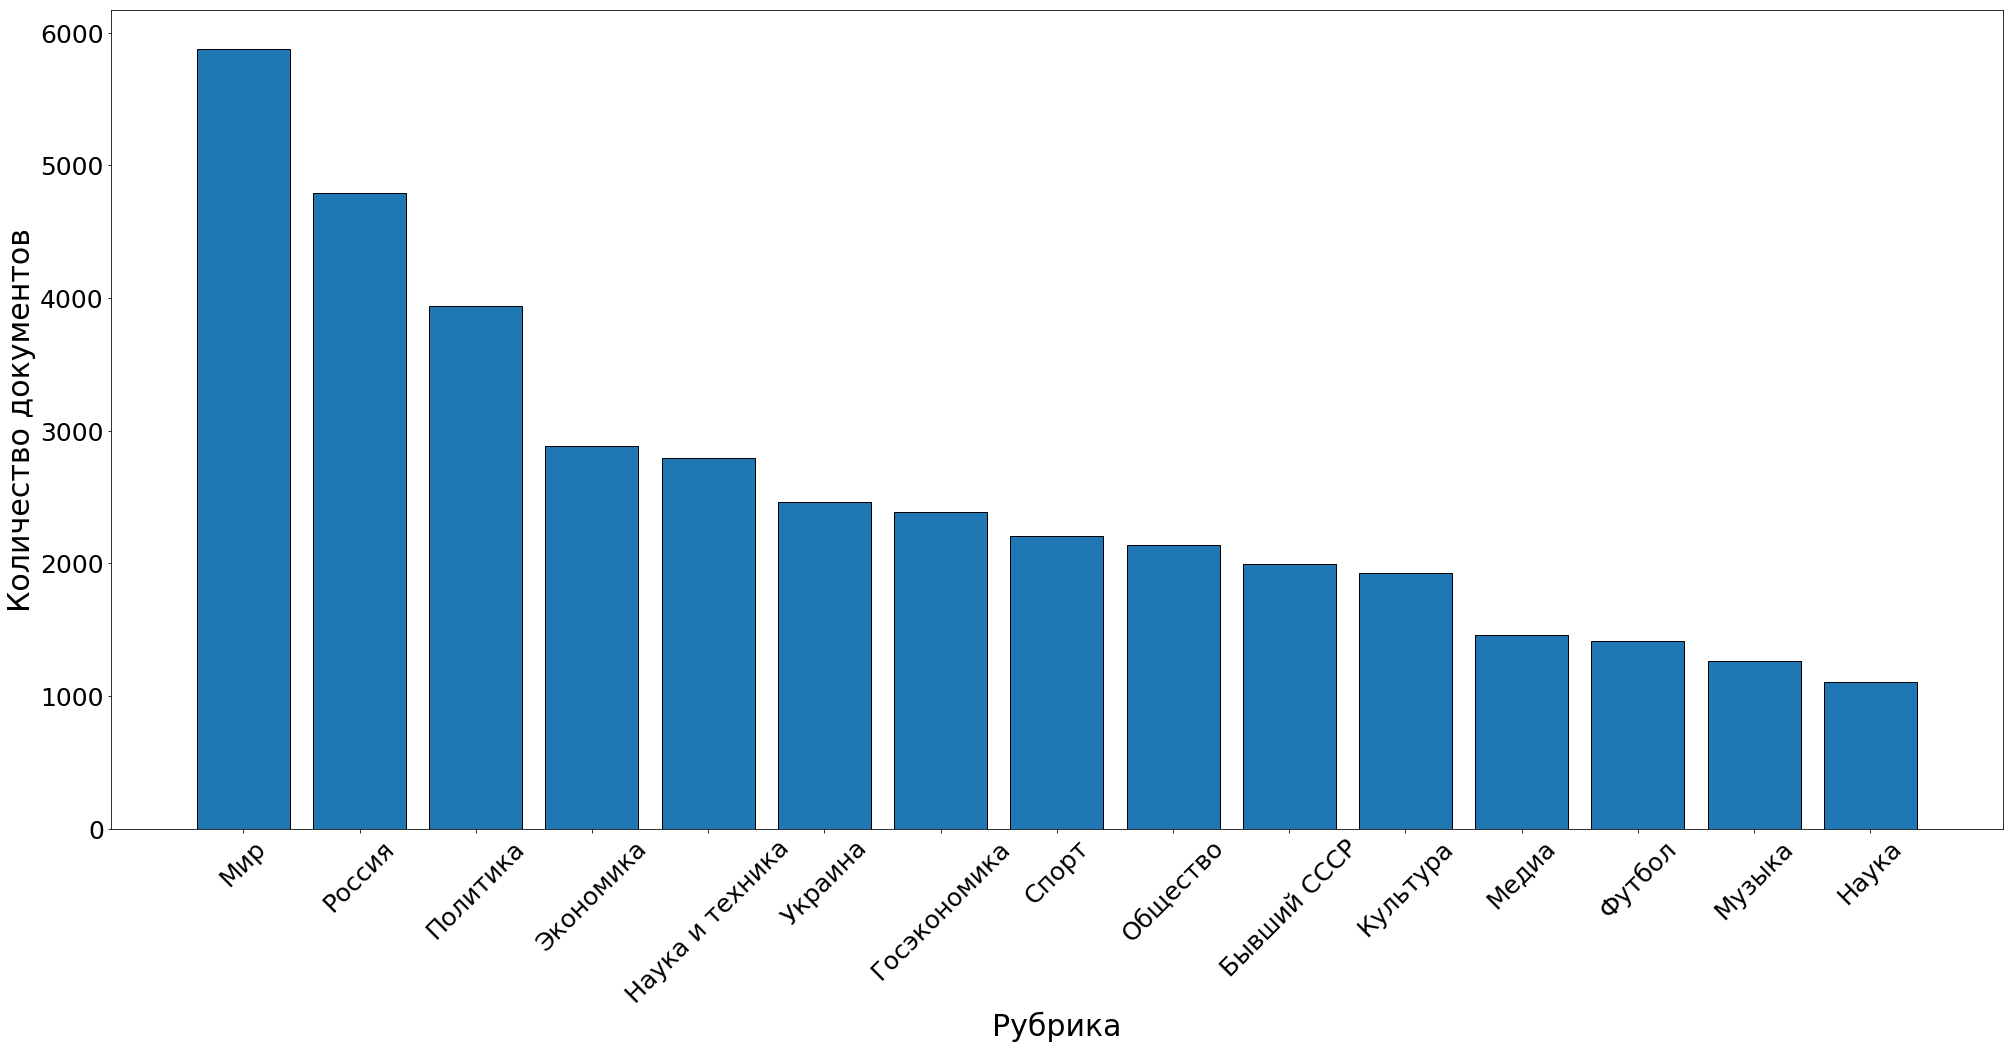

In [5]:
plt.figure(figsize=(28, 13))
ax = plt.subplot(1, 1, 1)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(25)
plt.xlabel('Рубрика', fontsize=30)
plt.ylabel('Количество документов', fontsize=30)
plt.xticks(rotation=45)
plt.tight_layout()
plt.bar(classes_balance.index, classes_balance, width=0.8, ec='black')
plt.show()

## Распределение количества слов в документе

In [6]:
numb_words = np.array(lenta.get_numb_words_dist())

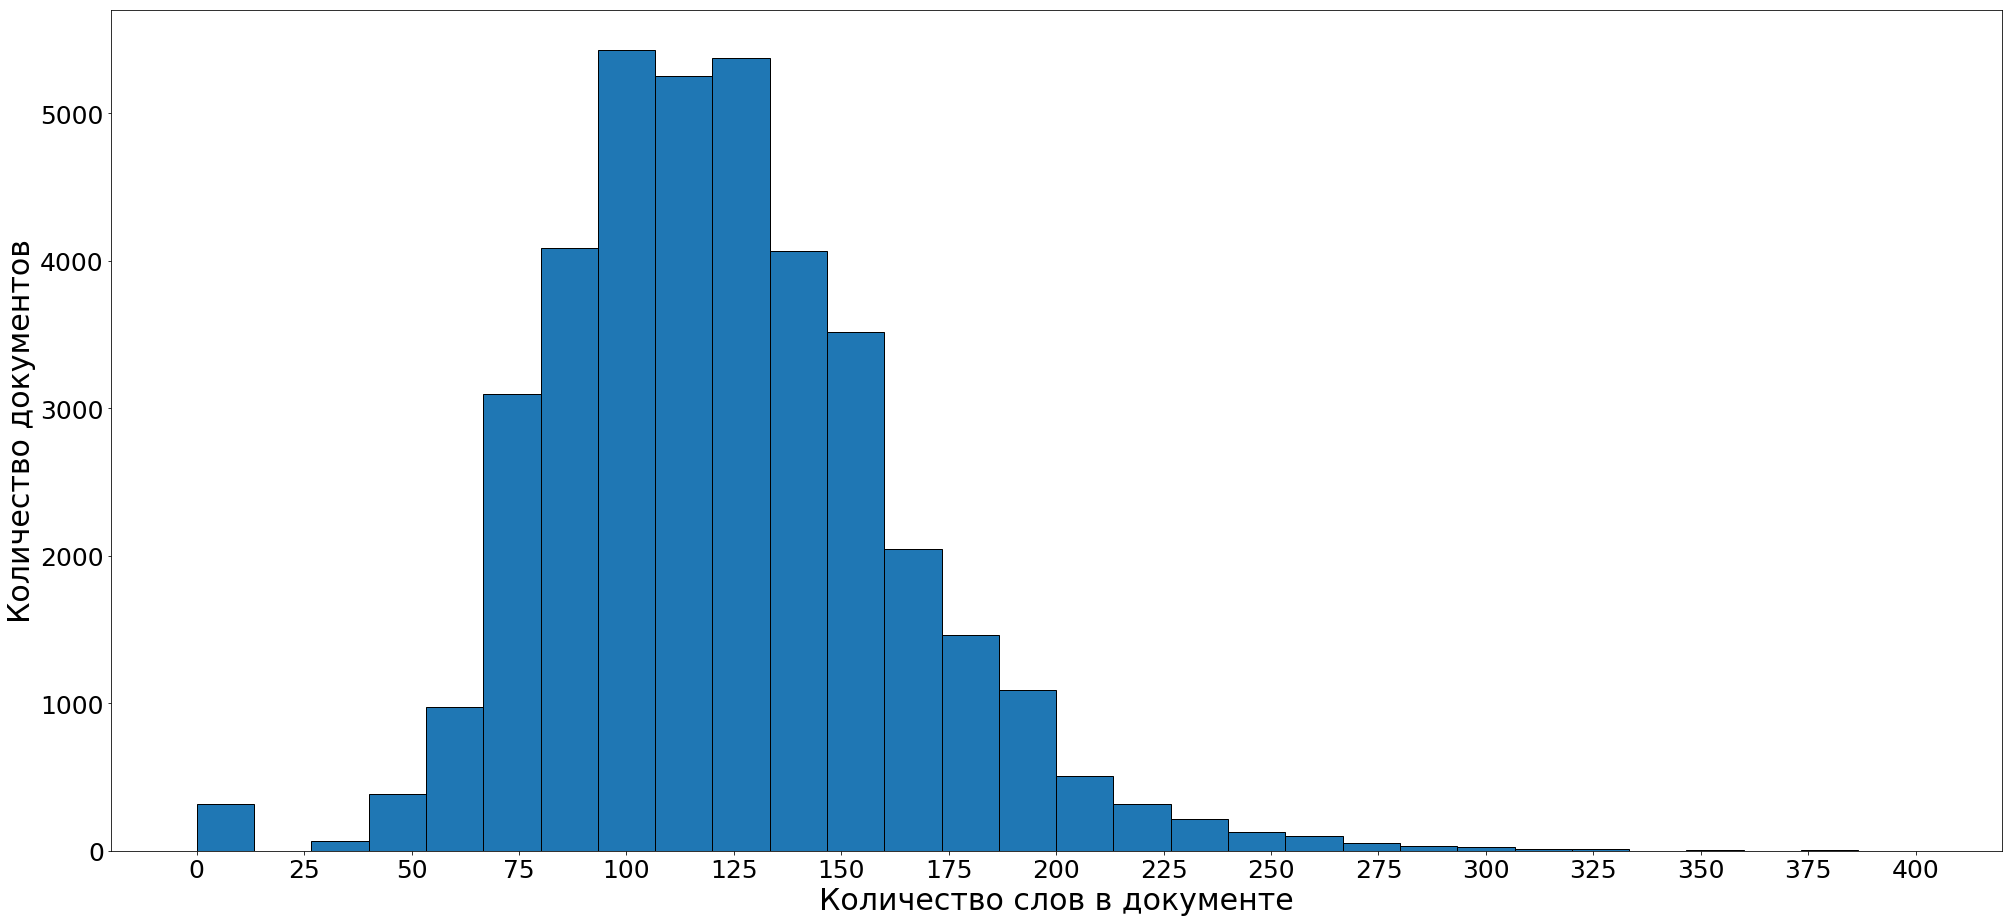

In [25]:
plt.figure(figsize=(28, 13))
ax = plt.subplot(1, 1, 1)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(25)
plt.xlabel('Количество слов в документе', fontsize=30)
plt.ylabel('Количество документов', fontsize=30)
plt.xticks([i for i in range(0, 500, 25)])
plt.tight_layout()
plt.hist(numb_words, ec='black', bins=30)
plt.show()

In [8]:
data = []
for rubric in rubrics:
    numb_words_class = np.array(lenta.get_numb_words_class_dist(rubric))
    numb_words_class = numb_words_class[numb_words_class < 1000]
    data.append(numb_words_class)

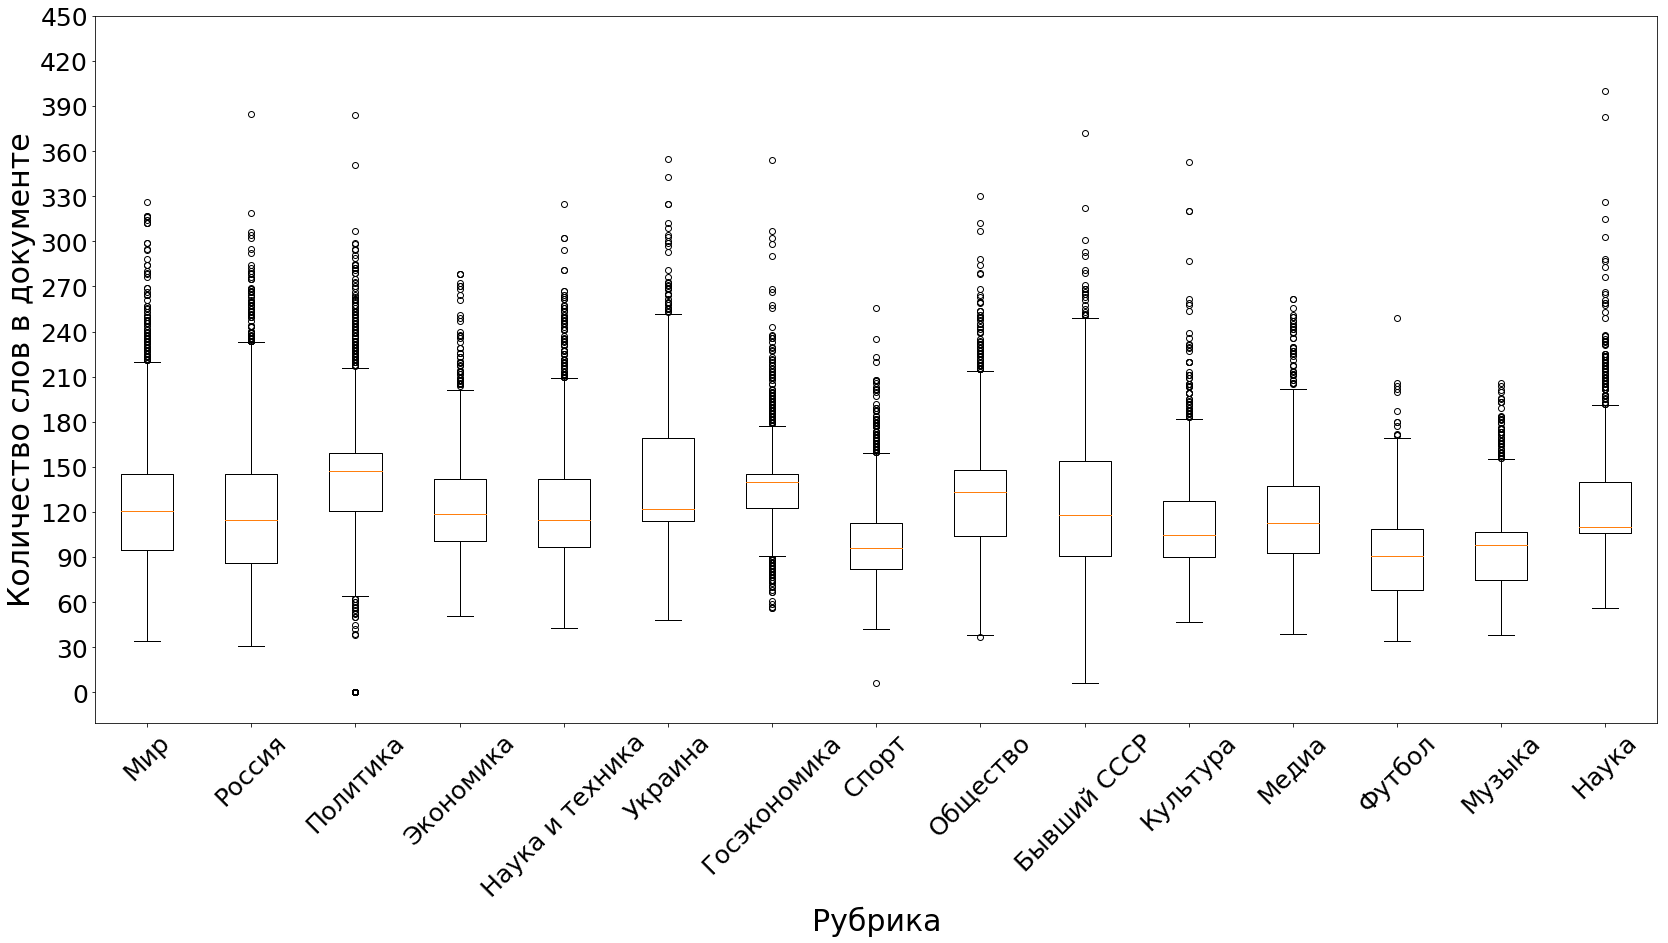

In [9]:
plt.figure(figsize=(28, 13))
ax = plt.subplot(1, 1, 1)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(25)
plt.xlabel('Рубрика', fontsize=30)
plt.ylabel('Количество слов в документе', fontsize=30)
plt.boxplot(data)
plt.xticks(range(1, len(rubrics) + 1), rubrics, rotation=45)
plt.yticks(range(0, 460, 30))
plt.show()

## Распределение частоты слов

In [10]:
word_freq_dist = lenta.get_word_freq_dist()

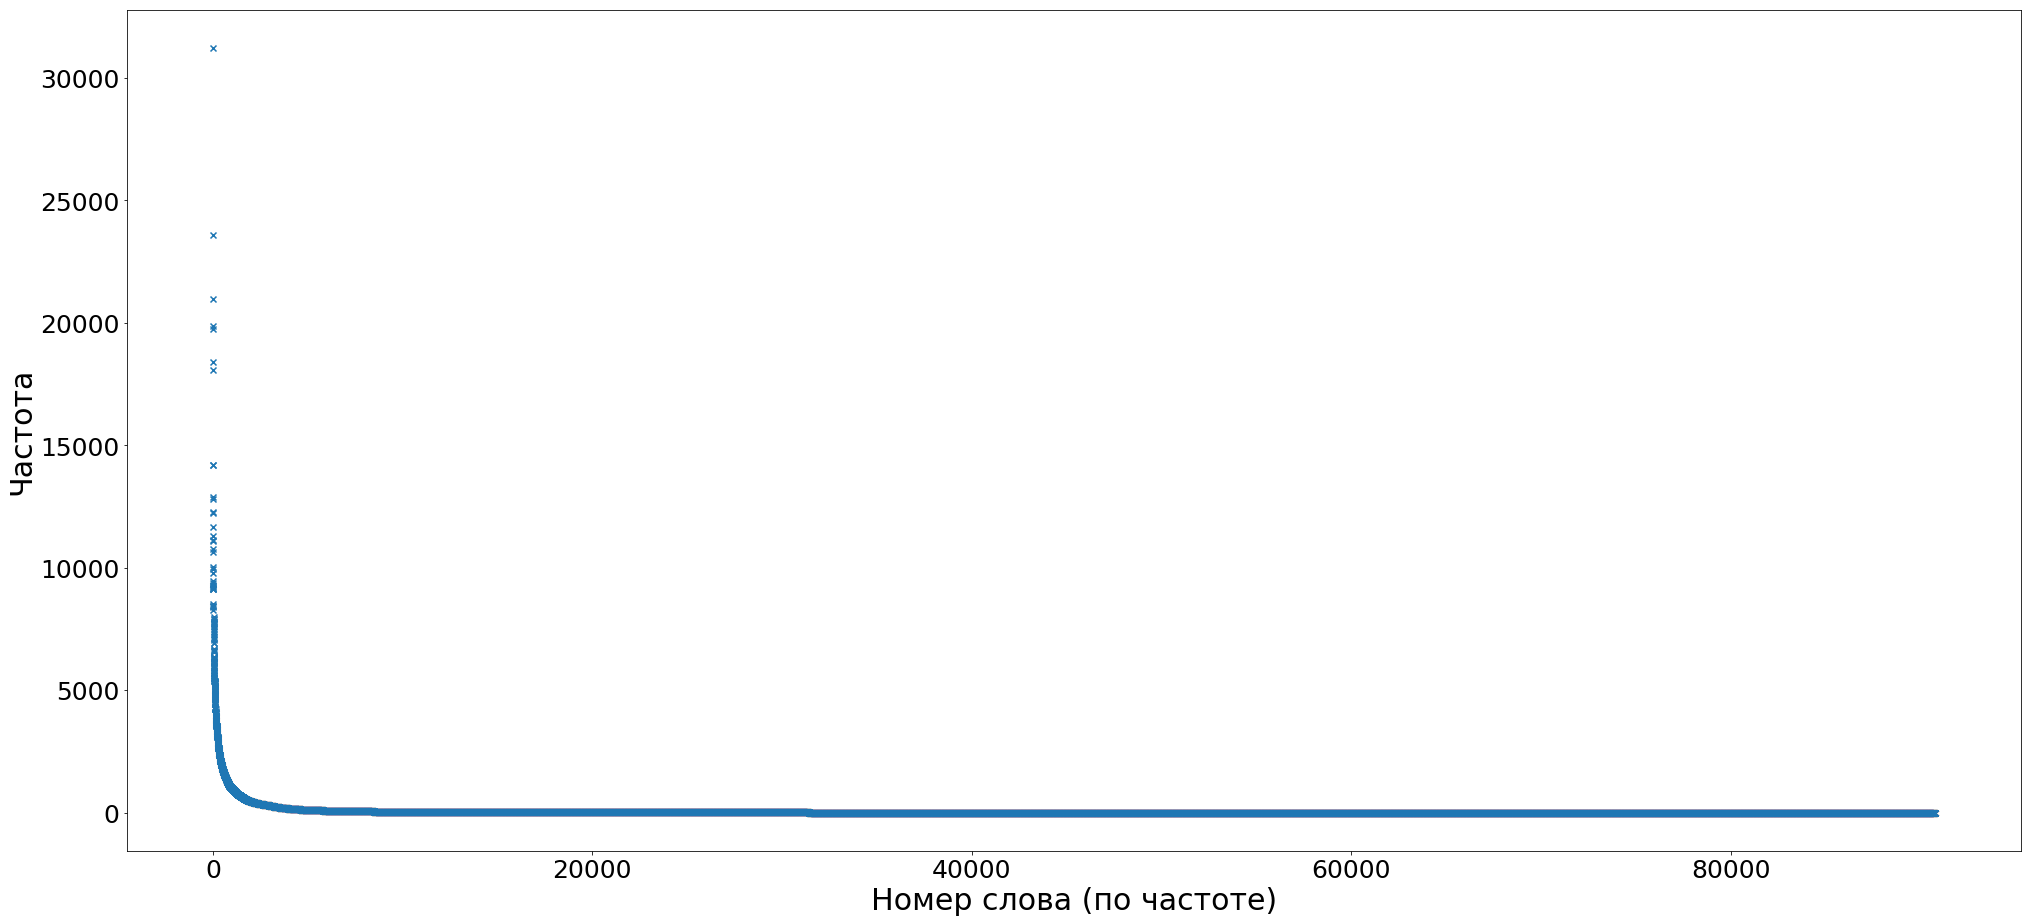

In [11]:
plt.figure(figsize=(28, 13))
ax = plt.subplot(1, 1, 1)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(25)
plt.ylabel('Частота', fontsize=30)
plt.xlabel('Номер слова (по частоте)', fontsize=30)
plt.tight_layout()
plt.scatter(range(0, len(word_freq_dist)), sorted(word_freq_dist, reverse=True), marker='x')
plt.show()

## Топ слов

In [12]:
top_words = lenta.get_top_words()

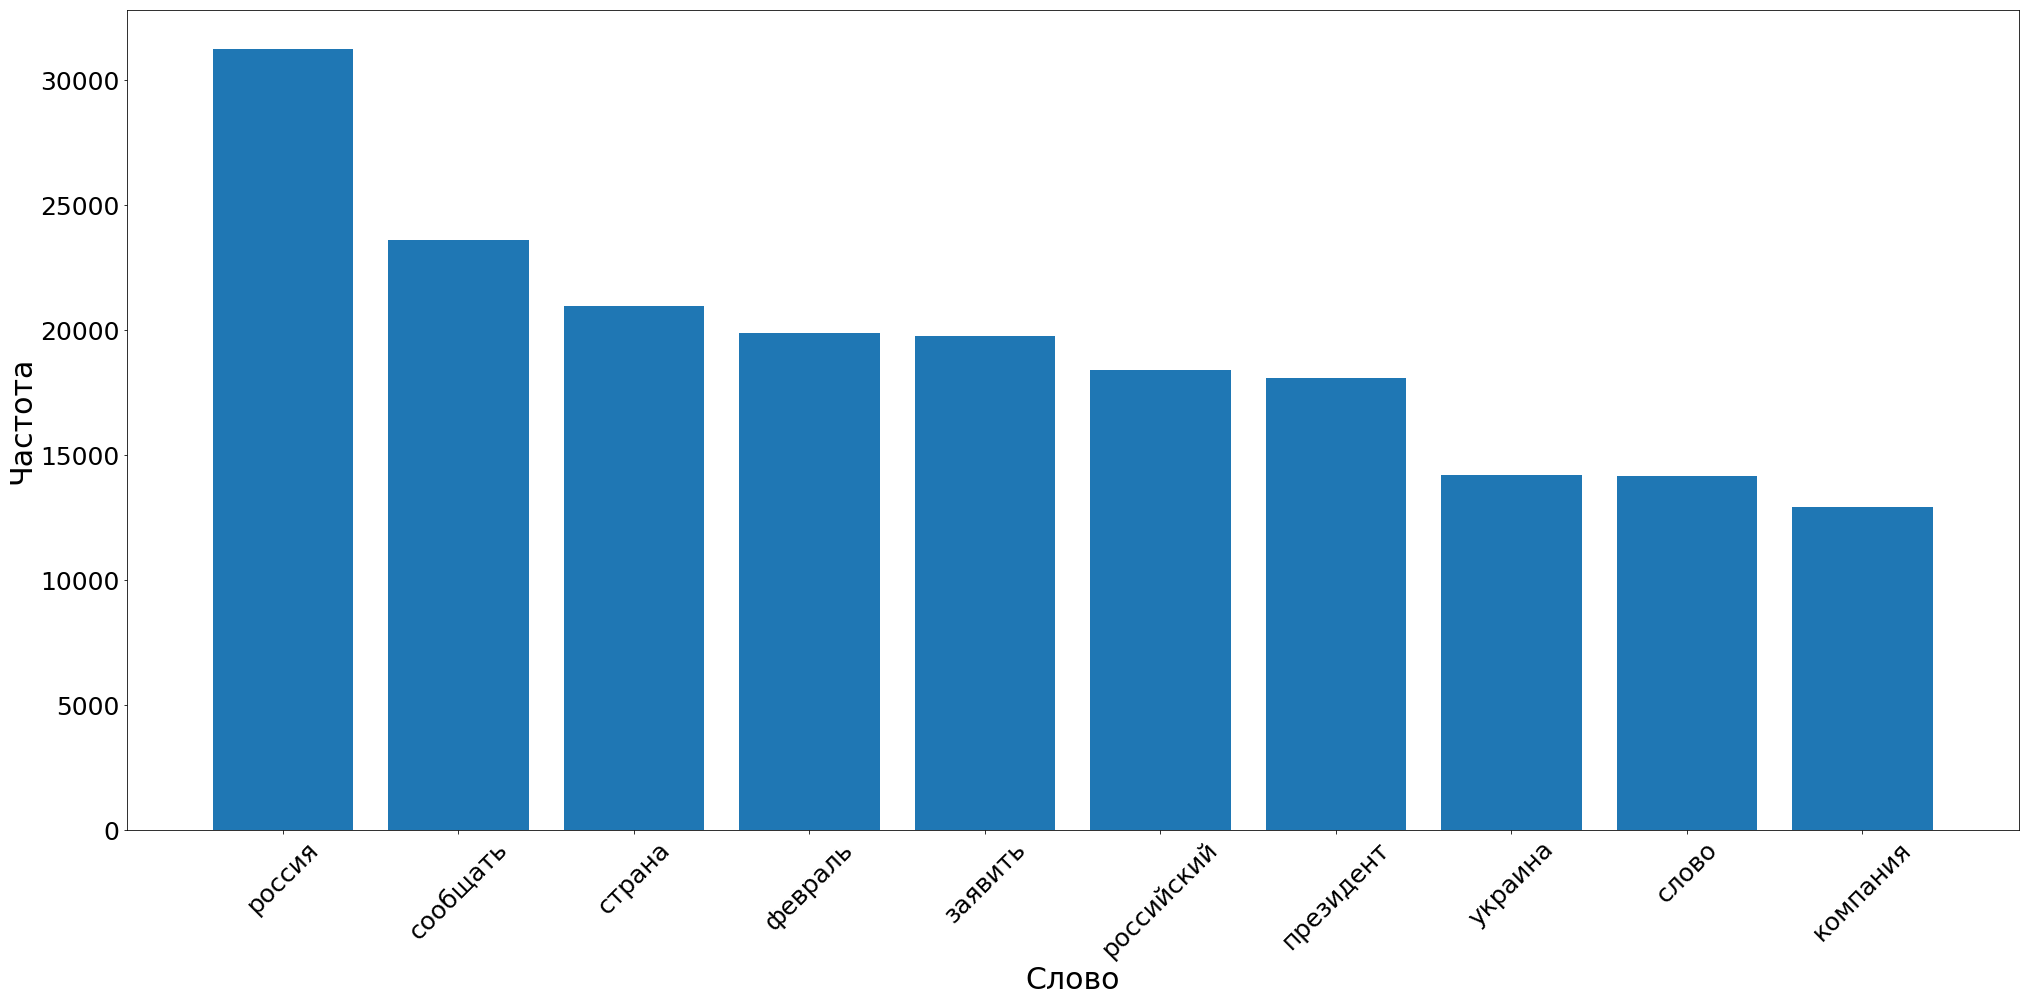

In [13]:
plt.figure(figsize=(28, 13))
ax = plt.subplot(1, 1, 1)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(25)
plt.ylabel('Частота', fontsize=30)
plt.xlabel('Слово', fontsize=30)
plt.xticks(rotation=45)
plt.tight_layout()
plt.bar(top_words.keys(), top_words.values())
plt.show()

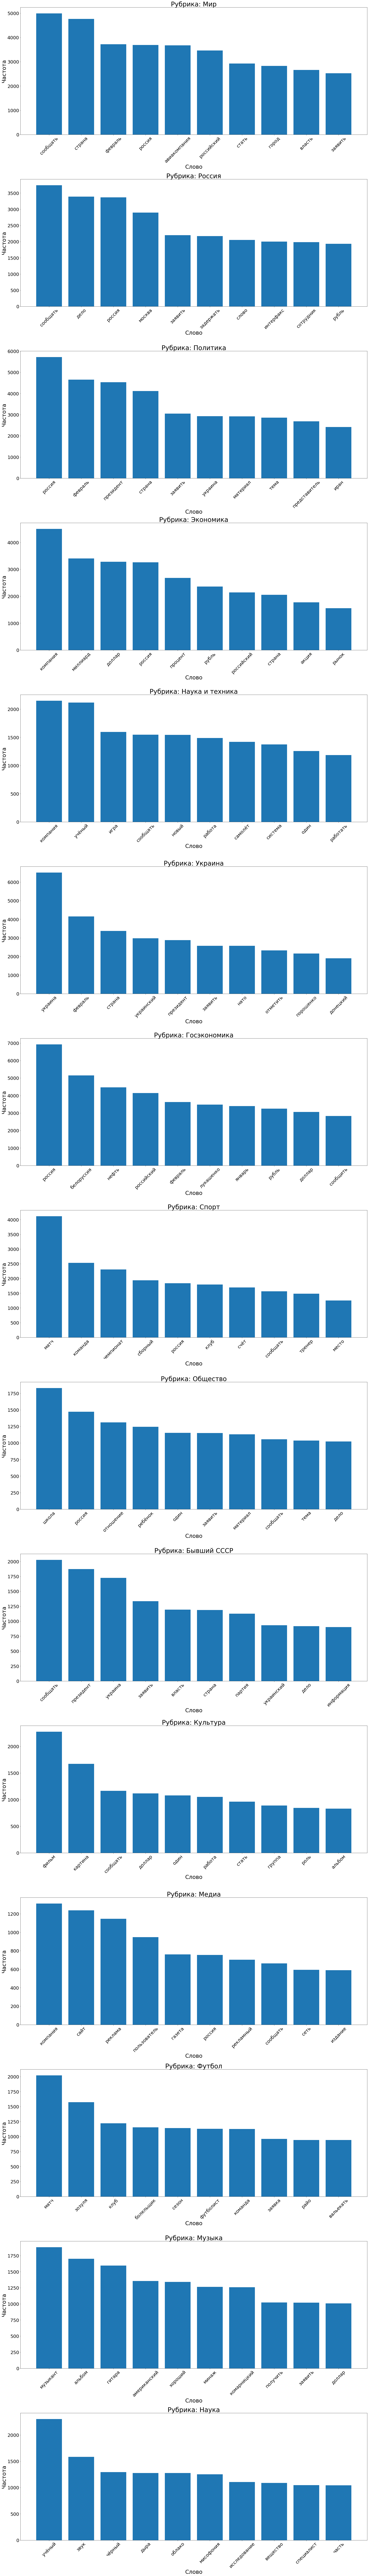

In [14]:
plt.figure(figsize=(28, 13 * len(rubrics)))

for i, rubric in enumerate(rubrics):
    top_words_rubric = lenta.get_top_words_class(rubric)
    ax = plt.subplot(len(rubrics), 1, i + 1)
    plt.title('Рубрика: {}'.format(rubric), fontsize=35)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(25)
    plt.ylabel('Частота', fontsize=30)
    plt.xlabel('Слово', fontsize=30)
    plt.xticks(rotation=45)
    plt.bar(top_words_rubric.keys(), top_words_rubric.values())
plt.tight_layout()
plt.show()

In [15]:
top_bigram = lenta.get_top_ngrams(10, 2)

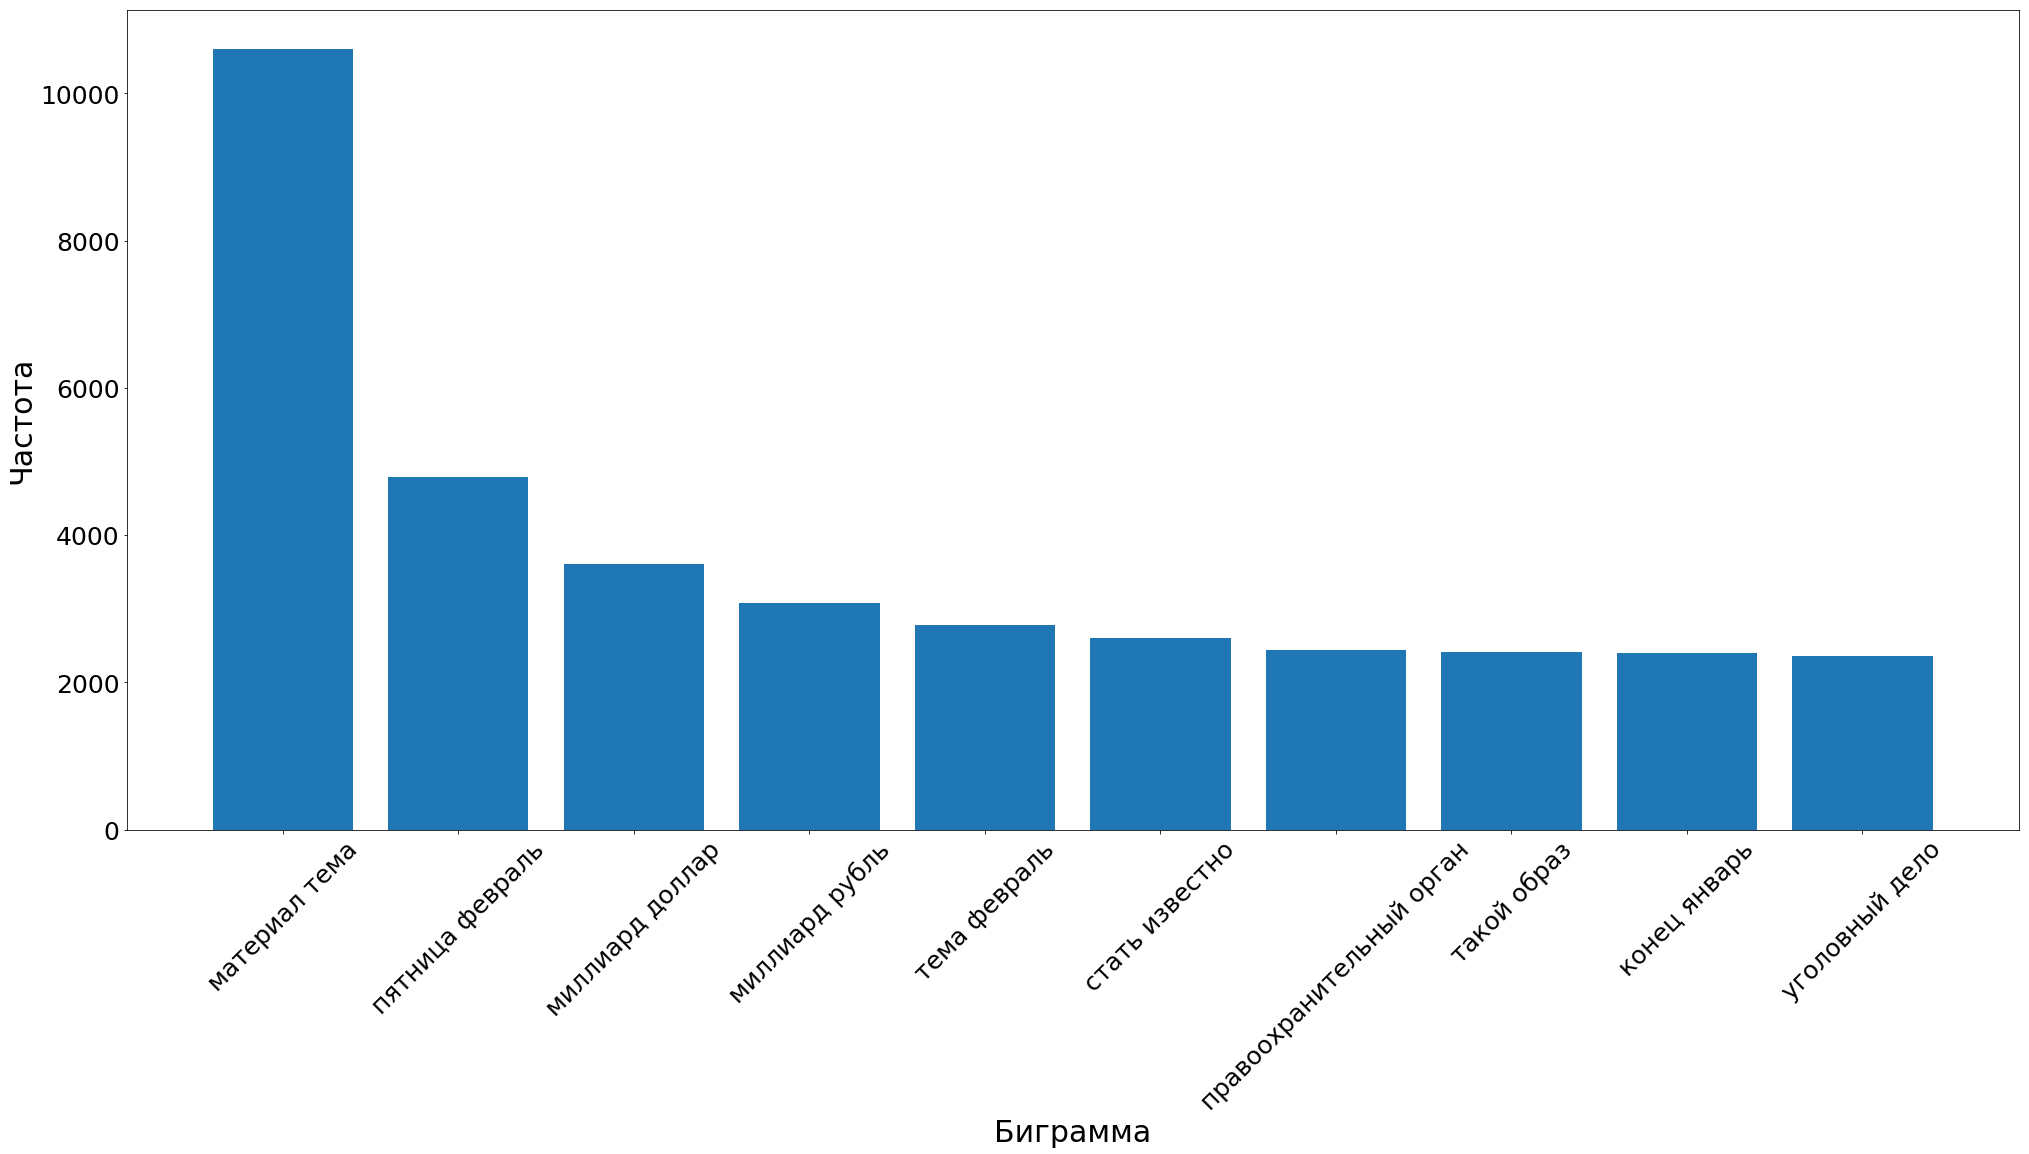

In [16]:
plt.figure(figsize=(28, 13))
ax = plt.subplot(1, 1, 1)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(25)
plt.ylabel('Частота', fontsize=30)
plt.xlabel('Биграмма', fontsize=30)
plt.xticks(rotation=45)
plt.tight_layout()
plt.bar(top_bigram.keys(), top_bigram.values())
plt.show()

# Feature extraction

In [7]:
def get_class_rate(y):
    y = np.array(y)
    n = len(y)
    for c in np.unique(y):
        print('Class - {}: {:.2f}%'.format(c, len(y[y == c]) / n))

In [8]:
X, y = lenta.get_data()

In [9]:
models = [
    DummyClassifier(strategy='most_frequent'),
    LogisticRegression(random_state=SEED),
    MultinomialNB(),
    GaussianNB(),
    SVC(),
    RandomForestClassifier(),
    XGBClassifier()
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [10]:
get_class_rate(y)

Class - Бывший СССР: 0.05%
Class - Госэкономика: 0.06%
Class - Культура: 0.05%
Class - Медиа: 0.04%
Class - Мир: 0.15%
Class - Музыка: 0.03%
Class - Наука: 0.03%
Class - Наука и техника: 0.07%
Class - Общество: 0.06%
Class - Политика: 0.10%
Class - Россия: 0.13%
Class - Спорт: 0.06%
Class - Украина: 0.06%
Class - Футбол: 0.04%
Class - Экономика: 0.08%


In [11]:
def save_result(name, res):
    with open('results/' + name + '.json', 'w') as output:
        json.dump(res, output)

In [12]:
transormations = ['bow', 'tf-idf', 'word2vec', 'word2vec_custom']

for trans in transormations:
    for model in models:
        clf = model
        
        if isinstance(model, DummyClassifier):
            transform = 'dummy'
        else:
            transform = trans
        
        # does not work with negative numbers
        if trans in ['word2vec', 'word2vec_custom'] and isinstance(model, MultinomialNB):
            continue
            
        pipeline = lenta.get_transform_pipeline(clf, transform, standardize=False)
        scores = cross_val_score(pipeline, X, y, verbose=10, cv=cv, n_jobs=5)
        mean = np.mean(scores)
        std = np.std(scores)
        res = {'mean': round(mean, 3), 'std': round(std, 3)}
        msg = 'Transformation: {}, Model: {}, accuracy {:.3f}(+- {:.3f})'
        print(msg.format(transform, model, mean, std))
        save_result(type(model).__name__ + '_' + trans, res)

[CV]  ................................................................
[CV] ...................... , score=0.15265200517464425, total=   0.1s
[CV]  ................................................................
[CV] ...................... , score=0.15344603381014305, total=   0.0s
[CV]  ................................................................
[CV] ...................... , score=0.15364583333333334, total=   0.0s


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.9s remaining:    0.6s


[CV]  ................................................................
[CV] ...................... , score=0.15334207077326342, total=   0.0s
[CV]  ................................................................
[CV] ...................... , score=0.15374507227332457, total=   0.0s


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.1s finished


Transformation: dummy, Model: DummyClassifier(constant=None, random_state=None, strategy='most_frequent'), accuracy 0.153(+- 0.000)


AttributeError: Can't pickle local object 'Dataset.__init__.<locals>.<lambda>'

## PCA

In [5]:
transormations = ['bow', 'tf-idf', 'word2vec', 'word2vec_custom']

for trans in transormations:
    for model in models:
        clf = model
        
        if isinstance(model, DummyClassifier):
            transform = 'dummy'
        else:
            transform = trans
        
        # does not work with negative numbers
        if isinstance(model, MultinomialNB):
            continue
            
        pipeline = lenta.get_transform_pipeline(clf, transform, standardize=stand, pca=True)
        scores = cross_val_score(pipeline, X, y, verbose=10, cv=cv, n_jobs=5)
        mean = np.mean(scores)
        std = np.std(scores)
        res = {'mean': round(mean, 3), 'std': round(std, 3)}
        msg = 'Transformation: {}, Model: {}, accuracy {:.3f}(+- {:.3f})'
        print(msg.format(transform, model, mean, std))
        save_result('pca_' type(model).__name__ + '_' + trans, res)

NameError: name 'models' is not defined